In [1]:
import argparse
import configparser
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from bts.models.data import Data, Sample
from bts.models.regression import SwitchPointBasicModel, SwitchPointModel, SwitchPointDiscreteModel, GaussianProcessModel

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

config = configparser.ConfigParser()
config.read(args.config_file)
args.s3_bucket = config.get('default', 's3_bucket')
args.s3_prefix = config.get('default', 's3_prefix')

In [3]:
sample = Sample(N=50, sp_loc=0.2, mu_1=1440, mu_2=1445, beta_1=0.03, beta_2=0.1, sigma_1=0.3, sigma_2=0.6)
sample_data = [sample.y, sample.t]

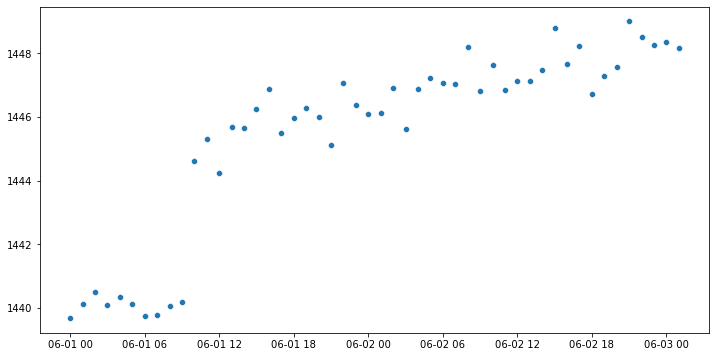

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, mu_2, mu_1, switch]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


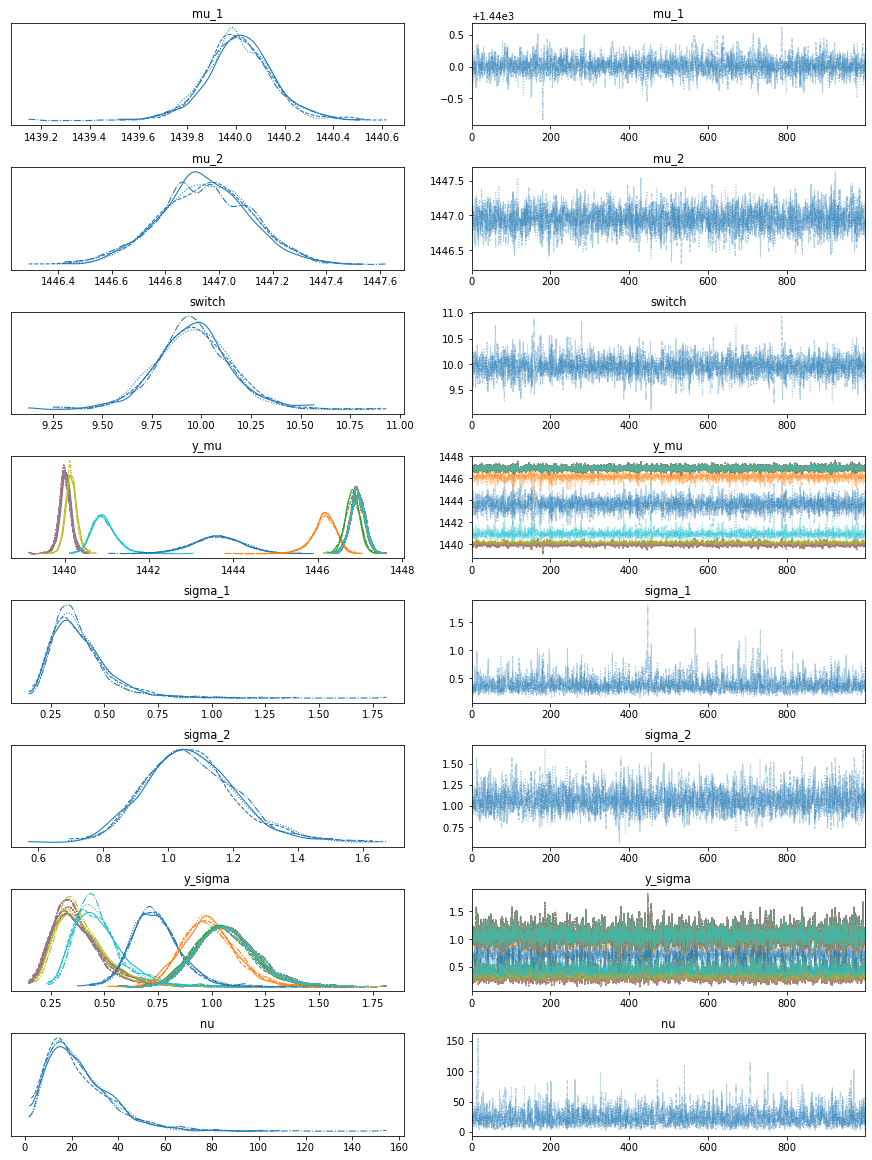

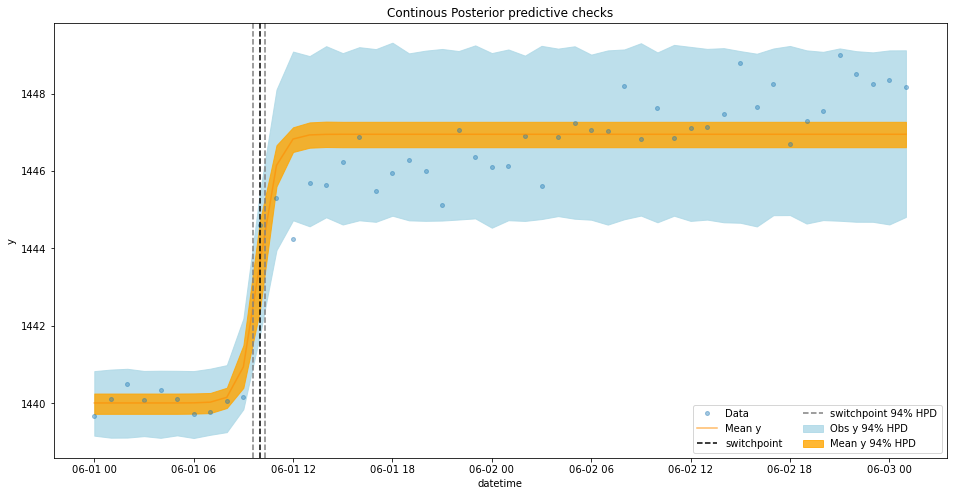

In [3]:
model = SwitchPointBasicModel(*sample_data)
model.define_model() 
model.fit()
model.plot_trace()
model.plot_posterior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, sigma_sensor, beta_2, beta_1, mu_2, mu_1, switch]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 30 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


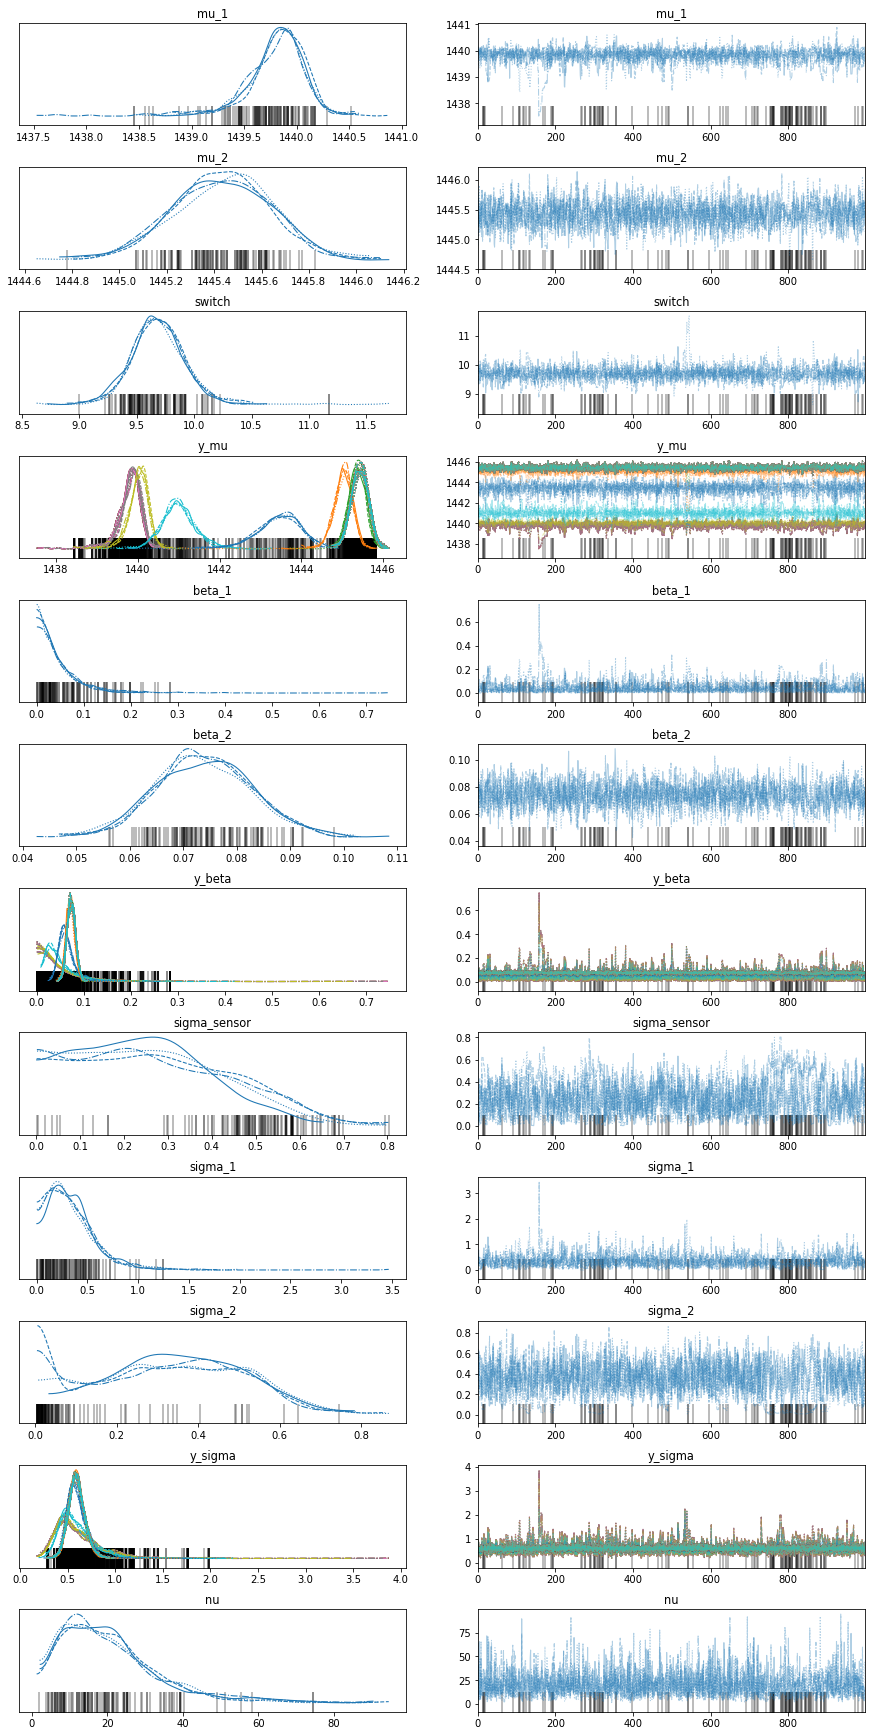

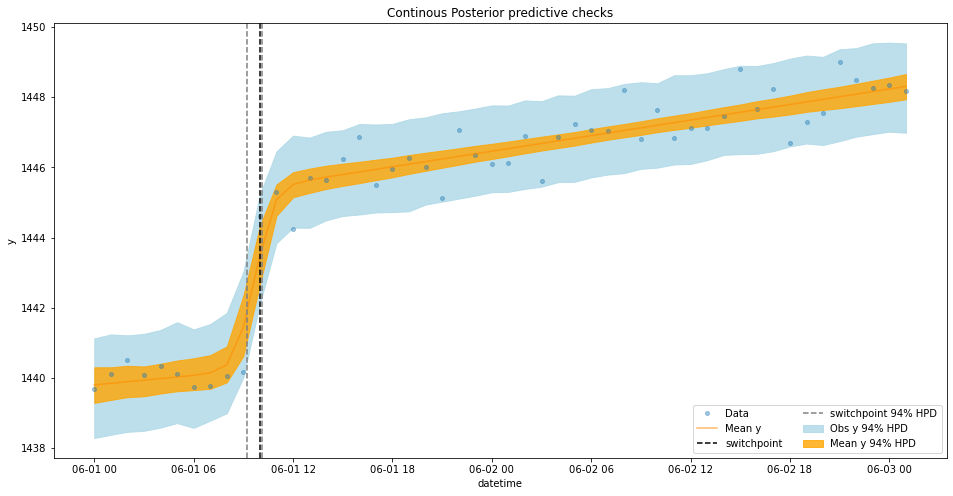

In [4]:
model = SwitchPointModel(*sample_data)
model.define_model() 
model.fit()
model.plot_trace()
model.plot_posterior_predictive()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switch]
>NUTS: [nu, sigma_2, sigma_1, sigma_sensor, beta_2, beta_1, mu_2, mu_1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
C:\Users\benyp\anaconda3\envs\pm\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


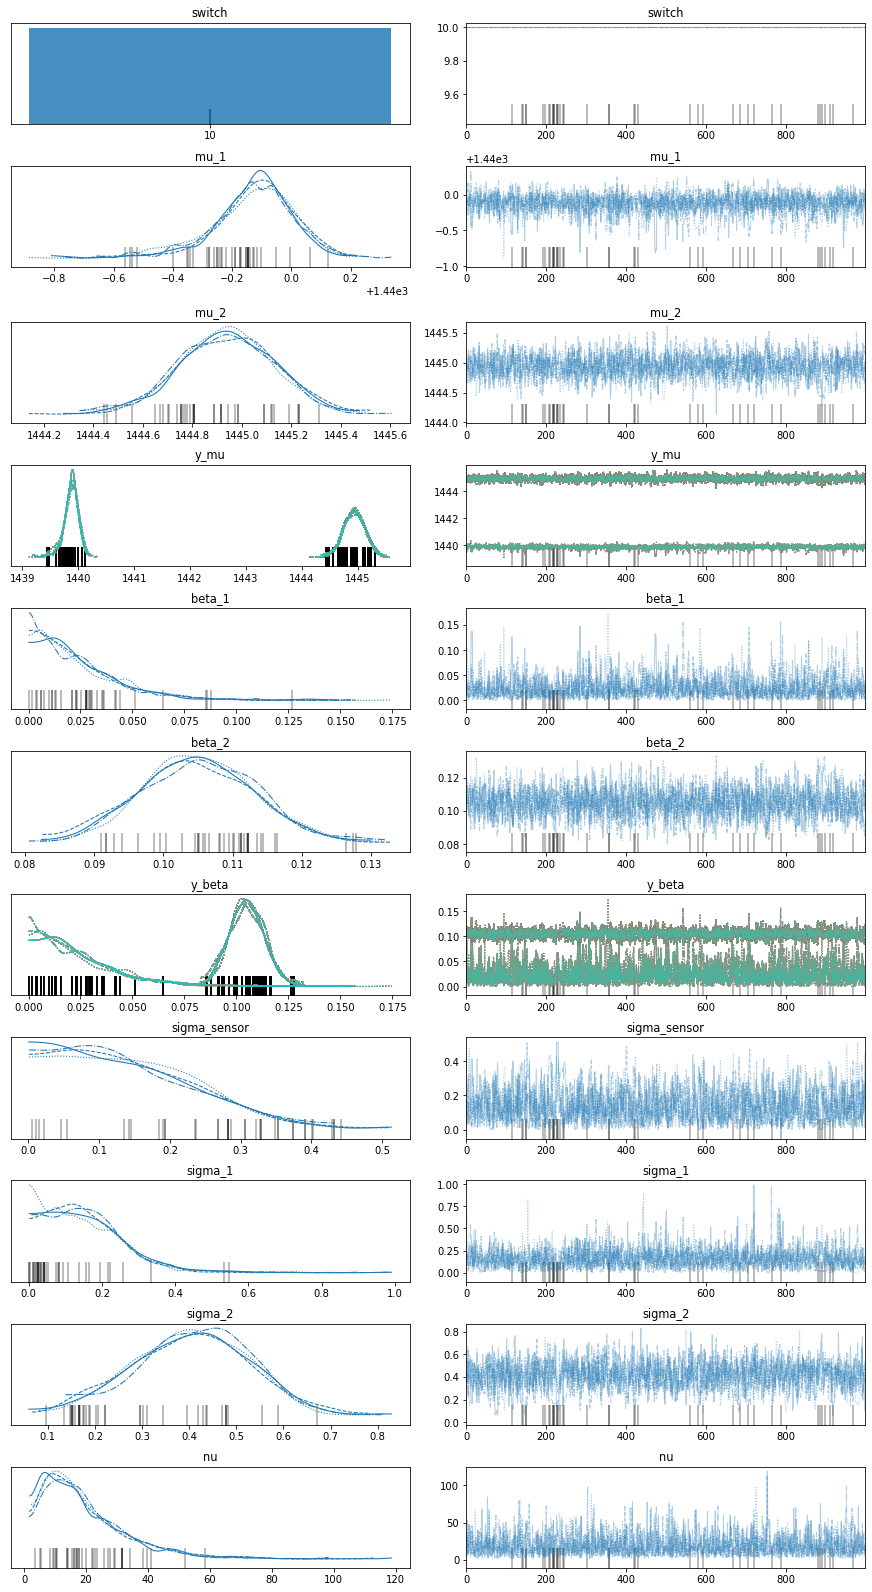

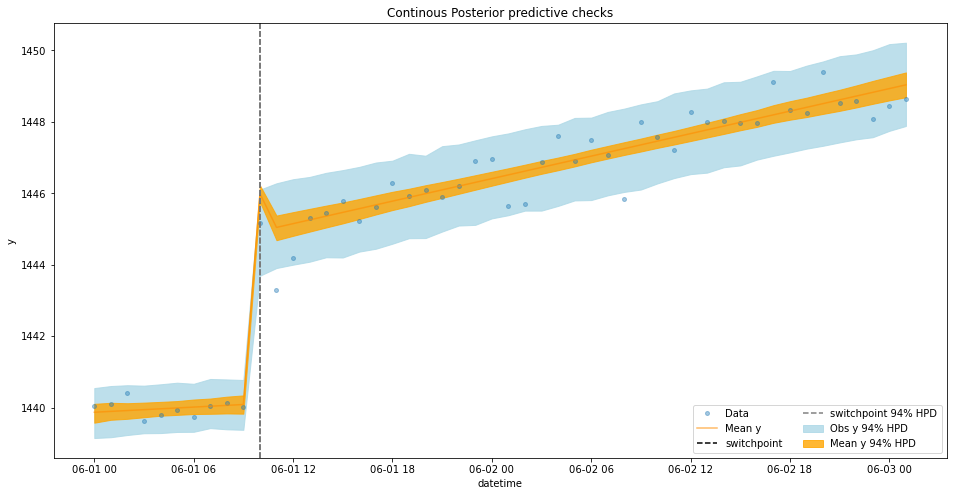

In [6]:
model = SwitchPointDiscreteModel(*sample_data)
model.define_model() 
model.fit()
model.plot_trace()
model.plot_posterior_predictive()

In [ ]:
y=sample_data[0]
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean)/y_std
X=sample_data[1][:, None]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 118 seconds.


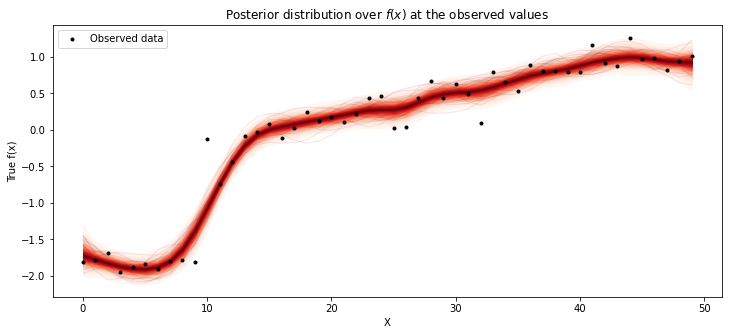

In [9]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();